<p>参考にしました</p>
<p>http://qiita.com/kenmatsu4/items/a0c703762a2429e21793</p>
<p>http://www.slideshare.net/shima__shima/2014-mtokyoscipy6</p>
<p>https://github.com/scipy-japan/tokyo-scipy/tree/master/006/shima__shima</p>
<p>岩波データサイエンス</p>
<p>データ解析のための統計モデリング入門</p>

In [284]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm2
import pymc3 as pm
import time 
import math
import numpy.random as rd
import pandas as pd
from pymc3 import summary

In [271]:
from pymc3.backends.base import merge_traces
import theano.tensor as T

<p>メトロポリス法</p>
<p>（１）パラメーターqの初期値を選ぶ</p>
<p>（２）qを増やすか減らすかをランダムに決める</p>
<p>（３）q（新）において尤度が大きくなるならqの値をq（新）に変更する</p>
<p>（４）q（新）で尤度が小さくなる場合であっても、確率rでqの値をq（新）に変更する</p>

In [116]:
def comb(n, r):
    if n == 0 or r == 0: return 1
    return comb(n, r - 1) * (n - r + 1) / r

def prob(n, y, q):
    p = comb(n, y) * q ** y * (1 - q) ** (n - y)
    return p

def likelighood(n, y, q):
    p = 1.0
    for i in y:
        p = p*prob(n, i, q)
    return p

def metropolis(n, y, q, b, num):
    qlist = np.array([q])
    for i in range(num):
        old_q = q
        q = q+np.random.choice([b, -b])
        old_l = likelighood(n, y, old_q)
        new_l = likelighood(n, y, q)
        if new_l > old_l:
            old_q = q
        else:
            r = new_l/old_l
            q = np.random.choice([q, old_q], p=[r, 1.0-r])
        q = round(q, 5)
        qlist = np.append(qlist, q)
    return q, qlist

In [122]:
y = [4, 3, 4, 5, 5, 2, 3, 1, 4, 0, 1, 5, 5, 6, 5, 4, 4, 5, 3, 4]

q, qlist = metropolis(8, y, 0.3, 0.01, 10000)

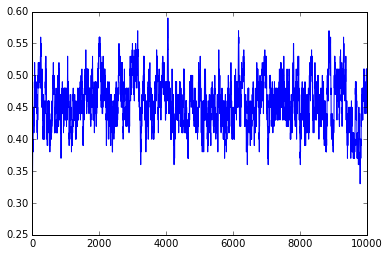

In [129]:
plt.plot(qlist)

(array([    8.,    11.,   202.,   996.,  2589.,  3185.,  2002.,   796.,
          198.,    14.]),
 array([ 0.3  ,  0.329,  0.358,  0.387,  0.416,  0.445,  0.474,  0.503,
         0.532,  0.561,  0.59 ]),
 <a list of 10 Patch objects>)

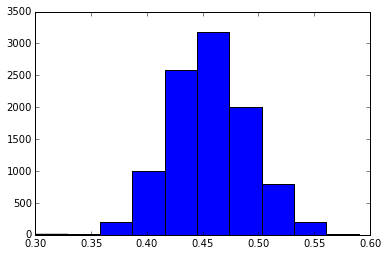

In [128]:
plt.hist(qlist)

In [245]:
qlist.mean()

0.45695930406959306

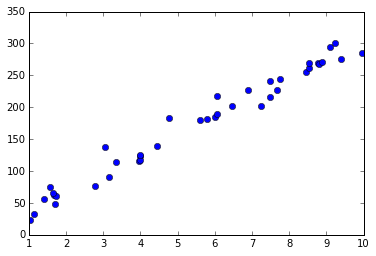

In [348]:
N = 40
X = np.random.uniform(10, size=N)
Y = X*30 + 4 + np.random.normal(0, 16, size=N)
plt.plot(X, Y, "o")

In [349]:
multicore = False
saveimage = False

itenum = 1000
t0 = time.clock()
chainnum = 3

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd =20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0)
    y = pm.Normal('y', mu=beta*X + alpha, sd=sigma, observed=Y)
    start = pm.find_MAP()
    step = pm.NUTS(state=start)

In [352]:
with model:
    if(multicore):
        trace = pm.sample(itenum, step, start=start,
                          njobs=chainnum, random_seed=range(chainnum),
                          progress_bar=False)
    else:
        ts = [pm.sample(itenum, step, chain=i, progressbar=False) for i in range(chainnum)]
         trace = merge_traces(ts)
    if(saveimage):
        pm.tracepot(trace).savefig("simple_linear_trace.png")
    print "Rhat="+str(pm.gelman_rubin(trace))
t1=time.clock()
print "elapsed time=" + str(t1-t0)
                

Rhat={'alpha': 0.99985044365753339, 'beta': 0.99984916717068217, 'sigma': 1.0196119762070879, 'sigma_interval': 1.0467762649550418}
elapsed time=373.267217


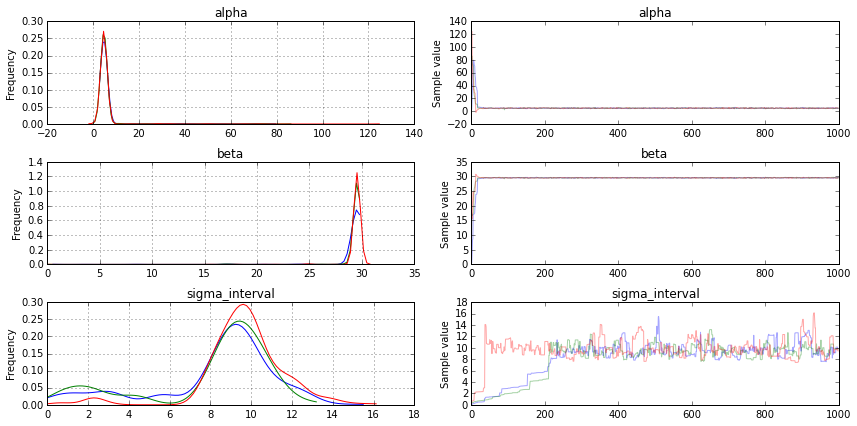

In [293]:
if(not multicore):
    trace = ts[0]
with model:
    pm.traceplot(trace, model.vars)

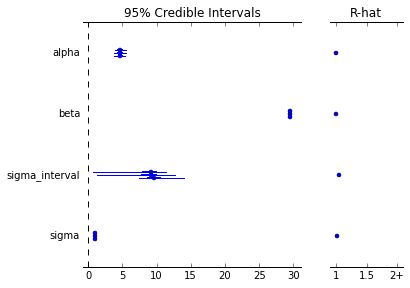

In [294]:
pm.forestplot(trace)

In [302]:
summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.261            5.751            0.324            [3.851, 5.497]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.935          4.434          4.708          4.982          5.722


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  29.388           1.588            0.093            [29.387, 29.690]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  29.356         29.487         29.540         29.589         29.676


sigma_interval:

  Mean             SD               MC Error         95% HPD interval
  --------------

In [ ]:
multicore = True

t0 = time.clock()

with model:
    if(multicore):
        trace = pm.sample(itenum, step, start=start,
                          njobs=chainnum, random_seed=range(chainnum),
                          progress_bar=False)
    else:
        ts = [pm.sample(itenum, step, chain=i, progressbar=False) for i in range(chainnum)]
        trace = merge_traces(ts)
    if(saveimage):
        pm.tracepot(trace).savefig("simple_linear_trace.png")
    print "Rhat="+str(pm.gelman_rubin(trace))
    
t1=time.clock()

print "elapsed time=" + str(t1-t0)

if(not multicore):
    trace = ts[0]
with model:
    pm.traceplot(trace, model.vars)

<p>例題：個体差と生存種子数</p>
ある植物を考える。i番目の個体の生存種子数をyiとする。yiは０以上8以下である。以下はヒストグラムである。

y,0,1,2,3,4,5,6,7,8
id,1074,691,459,137,315,192,402,830,950


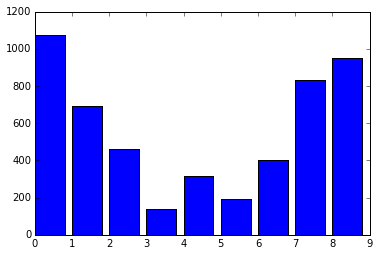

In [297]:
data = pd.read_csv("http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/hbm/data7a.csv")

plt.bar(range(9), data.groupby('y').sum().id)
data.groupby('y').sum().T

種子生存確率が9通の生存確率qの二項分布で説明できるとする。

<p>実際のデータを説明できていない。</p>
・・・個体差を考慮できるGLMMを用いる。

<p>logit(qi) = β + ri</p>
切片βは全個体に共通するパラメーター、riは個体差で平均0、標準偏差sの正規分布に従う。

事後分布∝p(Y|β, {ri})×事前分布

<p>βの事前分布には無情報事前分布を指定する。</p>
p(β)=1/√2π×100^2 × exp(-β^2/2×100^2)　

ERROR! Session/line number was not unique in database. History logging moved to new session 464


(array([   1.,    0.,    7.,   54.,  136.,  288.,  320.,  142.,   42.,   10.]),
 array([-481.28908973, -401.51224935, -321.73540897, -241.95856859,
        -162.18172821,  -82.40488784,   -2.62804746,   77.14879292,
         156.9256333 ,  236.70247368,  316.47931405]),
 <a list of 10 Patch objects>)

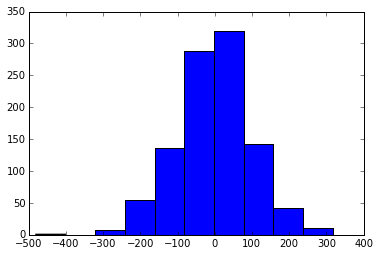

In [324]:
plt.hist(np.random.normal(0, 100, 1000))

<p>riの事前分布には平均0、標準偏差ｓの正規分布を仮定する。</p>
p(ri|s)=1/√2π×s^2 × exp(-ri^2/2×s^2)　

<p>sの事前分布には無情報事前分布を指定する。</p>
p(s)=(０から10^4までの連続一様分布)

In [298]:
Y = np.array(data.y)[:6]

yの数が大きく全て使うと時間がかかりすぎるので6体だけ選び出す。

 [-----------------100%-----------------] 1000 of 1000 complete in 3.6 sec

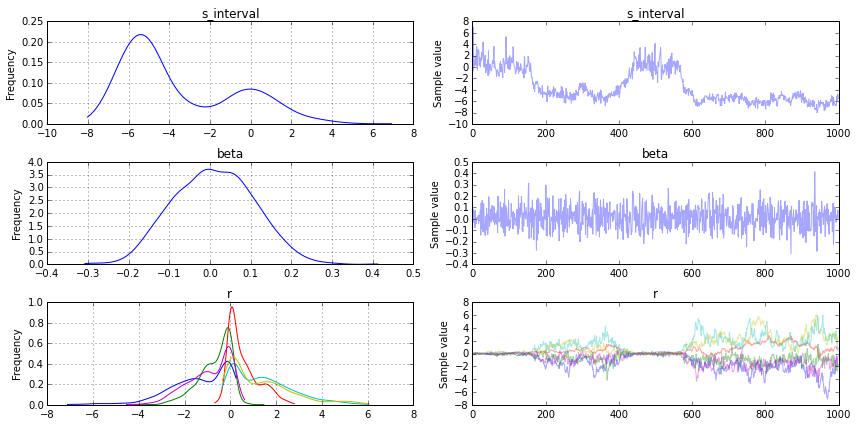

In [299]:
def invlogit(v):
    return T.exp(v)/(T.exp(v) + 1)

with pm.Model() as model_hier:
    s = pm.Uniform('s', 0, 1.0E+2)
    beta = pm.Normal('beta', 0, 1.0E+2)
    r = pm.Normal('r', 0, s, shape=len(Y))
    q = invlogit(beta+r)
    y = pm.Binomial('y', 8, q, observed=Y) #p(q|Y)
    
    step = pm.Slice([s, beta, r])
    trace_hier = pm.sample(1000, step)
    
with model_hier:
    pm.traceplot(trace_hier, model_hier.vars)

In [322]:
summary(trace_hier)


s_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -3.505           2.845            0.274            [-7.096, 1.905]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.923         -5.670         -4.714         -0.824         2.449


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.010            0.098            0.003            [-0.177, 0.184]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.168         -0.063         0.008          0.079          0.199


r:

  Mean             SD               MC Error         95% HPD interval
  -----------------------

In [323]:
trace_hier

<MultiTrace: 1 chains, 1000 iterations, 4 variables>

 [-----------------100%-----------------] 10000 of 10000 complete in 3.1 sec

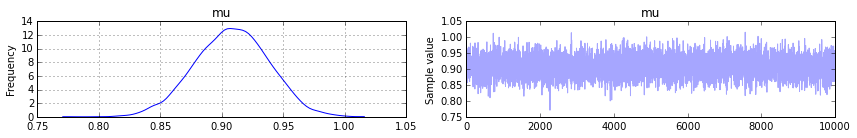

In [278]:
x_sample = np.random.normal(loc=1.0, scale=1.0, size=1000)

with pm.Model() as model:
	mu = pm.Normal('mu', mu=0., sd=0.1)
	x = pm.Normal('x', mu=mu, sd=1., observed=x_sample)

with model:
	start = pm.find_MAP()
	step = pm.NUTS()
	trace = pm.sample(10000, step, start)

pm.traceplot(trace)
plt.savefig("result1.jpg")

 [-----------------100%-----------------] 10000 of 10000 complete in 9.8 sec

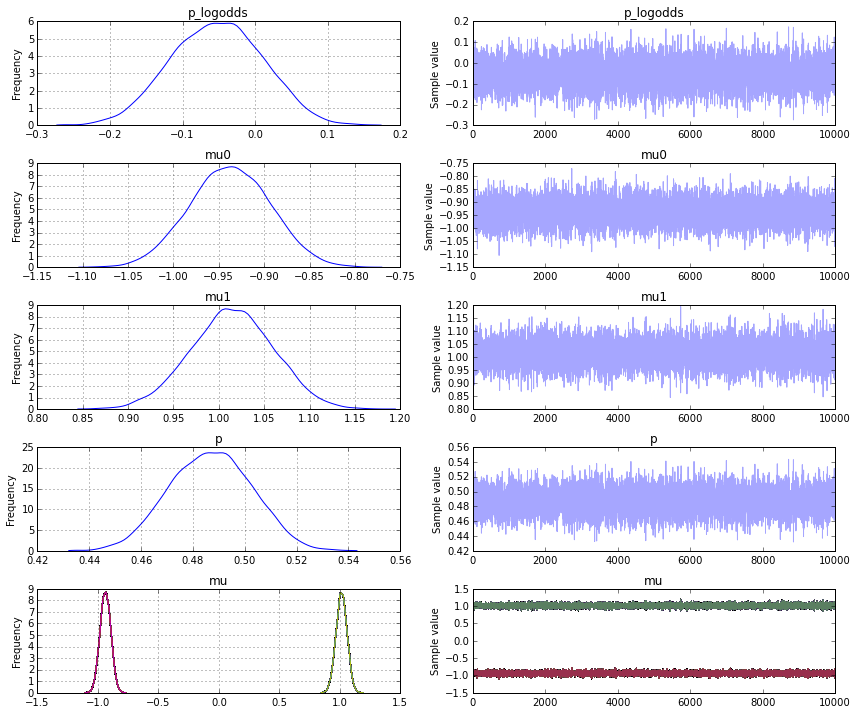

In [282]:
ndims = 2
nobs = 20

n = 1000
y_sample = np.random.binomial(1, 0.5, size=(n,))
x_sample=np.empty(n)
x_sample[y_sample==0] = np.random.normal(-1, 1, size=(n, ))[y_sample==0]
x_sample[y_sample==1] = np.random.normal(1, 1, size=(n, ))[y_sample==1]

with pm.Model() as model:
	p = pm.Beta('p', alpha=1.0, beta=1.0)
	y = pm.Bernoulli('y', p=p, observed=y_sample)
	mu0 = pm.Normal('mu0', mu=0., sd=1.)
	mu1 = pm.Normal('mu1', mu=0., sd=1.)

	mu = pm.Deterministic('mu', mu0 * (1-y_sample) + mu1 * y_sample)
	
	x = pm.Normal('x', mu=mu, sd=1., observed=x_sample)

with model:
	start = pm.find_MAP()
	step = pm.NUTS()
	trace = pm.sample(10000, step, start)

pm.traceplot(trace)
plt.savefig("result2.jpg")